<div style="background-color: #FFDDDD; border-left: 5px solid red; padding: 10px; color: black;">
    <strong>Kernel:</strong> Python 3 (ipykernel)
</div>

In [ ]:
%pip install -Uq sagemaker==2.232.0 ultralytics==8.2.100 datasets==2.18.0 matplotlib seaborn qai-hub

# [YOLOv8](https://yolov8.com/) Amazon SageMaker and Qualcomm model fine-tuning Notebook

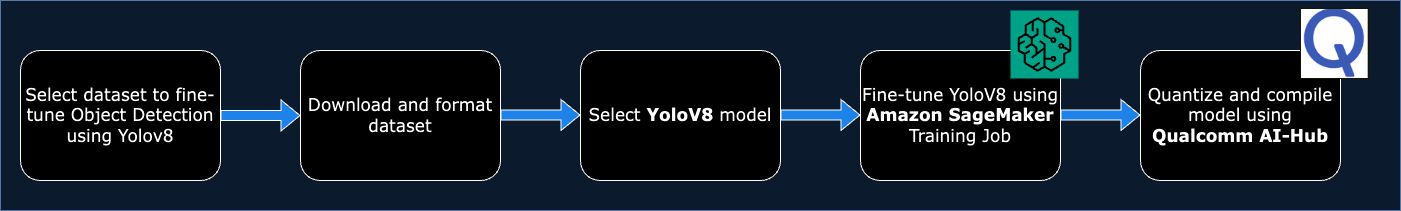

The workflow illustrates the process of fine-tuning a YOLOv8 object detection model using [Amazon SageMaker](https://aws.amazon.com/pm/sagemaker/) and optimizing it for deployment using [Qualcomm AI Hub](https://aihub.qualcomm.com/). 

We start by selecting and downloading a suitable dataset for object detection task, which is then formatted for the YOLOv8 model. After choosing the YOLOv8 model, it is fine-tuned using an Amazon SageMaker training job, ensuring the model is well-adapted to the specific dataset. Finally, the fine-tuned model is quantized and compiled using Qualcomm AI-Hub, making it ready for optimized deployment on edge devices. This end-to-end flow integrates multiple tools to ensure both high model performance and deployment efficiency.

In [ ]:
import os
import sys

sys.path.append(os.path.dirname(os.getcwd()))

import glob
import tarfile
import boto3
import yaml
import sagemaker
import cv2
import time
from datetime import datetime
import torch
import random
import shutil
from datasets import Dataset
import ultralytics
from ultralytics import YOLO
import matplotlib.pyplot as plt 
import numpy as np
from PIL import Image, ImageDraw, ImageFont
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.image_uris import retrieve
from scripts.utils.prepare_dataset import CreateYoloHFDataset
from scripts.utils.helpers import (
    download_tar_and_untar,
    build_image_label_pairs,
    draw_bounding_boxes,
    create_image_mosaic,
    create_metrics_plots
)

In [ ]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

set_seed()

## Setup

In [ ]:
session = sagemaker.Session()
role = get_execution_role()
session_datetime_prefix = datetime.now().strftime('%Y%m%d%H%M')
s3_bucket = session.default_bucket()   

In [ ]:
print("CUDA Available: " + str(torch.cuda.is_available()))
print("Torch CUDA Version: " + str(torch.version.cuda))

In [ ]:
ultralytics.utils.checks.collect_system_info()

## Data Preparation

### Ultralytics YOLO Dataset Structure

When preparing datasets for training with Ultralytics YOLO (e.g., YOLOv5, YOLOv8), it's essential to organize the dataset in a specific folder structure that the framework expects. This structure helps YOLO correctly load and process the images and labels during the training phase.

Below is the standard directory layout and the expected file formats:

#### 1. Directory Structure

Your dataset directory should have the following structure:

```
/path/to/dataset
│
├── images
│   ├── train
│   │   ├── image1.jpg
│   │   ├── image2.jpg
│   │   └── ...
│   ├── val
│   │   ├── image1.jpg
│   │   ├── image2.jpg
│   │   └── ...
│   └── test  # Optional
│       ├── image1.jpg
│       ├── image2.jpg
│       └── ...
│
├── labels
│   ├── train
│   │   ├── image1.txt
│   │   ├── image2.txt
│   │   └── ...
│   ├── val
│   │   ├── image1.txt
│   │   ├── image2.txt
│   │   └── ...
│   └── test  # Optional
│       ├── image1.txt
│       ├── image2.txt
│       └── ...
│
└── data.yaml
```

#### 2. Folder Descriptions

- **`images/train`**: Contains all training images.
- **`images/val`**: Contains all validation images.
- **`images/test`** (optional): Contains all test images, if available.

- **`labels/train`**: Contains the corresponding label files for the training images. Each label file has the same name as the associated image but with a `.txt` extension.
- **`labels/val`**: Contains the corresponding label files for the validation images.
- **`labels/test`** (optional): Contains the corresponding label files for the test images.

#### 3. Label File Format (`.txt` files)

Each image should have a corresponding label file in the `labels/` directory. The label file should be a plain text file containing the bounding box information in the following format:

```
class_id x_center y_center width height
```

- **`class_id`**: Index of the class (0-indexed).
- **`x_center`**: X-coordinate of the center of the bounding box (normalized by the image width).
- **`y_center`**: Y-coordinate of the center of the bounding box (normalized by the image height).
- **`width`**: Width of the bounding box (normalized by the image width).
- **`height`**: Height of the bounding box (normalized by the image height).

Each line in the label file corresponds to one object in the image.

#### 4. `data.yaml` File

The `data.yaml` file defines the dataset configuration, including paths to the images, number of classes, and class names. Here’s a sample structure:

```yaml
train: /path/to/dataset/images/train
val: /path/to/dataset/images/val
test: /path/to/dataset/images/test  # Optional

nc: 2  # Number of classes
names: ['class0', 'class1']  # Class names
```

- **`train`**: Path to the training images.
- **`val`**: Path to the validation images.
- **`test`**: Path to the test images (optional).
- **`nc`**: Number of classes.
- **`names`**: List of class names.

In [ ]:
dataset_name = "keremberke/pcb-defect-segmentation"
dataset_labels = [
    'dry_joint', 
    'incorrect_installation', 
    'pcb_damage', 
    'short_circuit'
]

This function, part of the `CreateYoloHFDataset` class, converts a Hugging Face dataset into the YOLO format for object detection tasks. It takes a Hugging Face dataset name and a list of label names as input, loads the dataset, and processes the images and their corresponding bounding box annotations. The function saves the images and labels in a structured local directory, creating separate folders for each data split (e.g., train, validation). For each image, the bounding box coordinates are normalized to the YOLO format, and the corresponding labels are saved in text files. Additionally, it builds a `data.yaml` file, which specifies the dataset structure and paths, necessary for training a YOLO model.

This class provides functionality to transform and store Hugging Face datasets locally in a format compatible with YOLO object detection models, including organizing images, labels, and creating the required configuration file for training.

In [ ]:
data = CreateYoloHFDataset(
    hf_dataset_name=dataset_name, 
    labels_names=dataset_labels
)

Select a local path to save these files to and write images and normalized labels to disk!

In [ ]:
data_path = "/tmp/dataset/local"
data.create_local_dataset(
    data_write_path=data_path
)

### Modifications of `data.yaml` `path` to SageMaker Training

This is the default `data.yaml` format before modifying it to identify data source inside SageMaker training

```yaml
names:
  0: dry_joint
  1: incorrect_installation
  2: pcb_damage
  3: short_circuit
path: /home/user/local/path  ## Local path
test: images/test
train: images/train
validation: images/validation
```

We change the `path` from local to remote training jobs

```yaml
names:
  0: dry_joint
  1: incorrect_installation
  2: pcb_damage
  3: short_circuit
path: /opt/ml/input/data/training  ## Remote training path
test: images/test
train: images/train
validation: images/validation
```

In [ ]:
with open(
    data.data_yaml["data_yaml"], 'r'
) as file:
    data_yaml_file = yaml.safe_load(file)
    
data_yaml_file["path"] = "/opt/ml/input/data/training"

with open(
    os.path.join(os.path.dirname(data.data_yaml["data_yaml"]), "data_job.yaml"), 'w'
) as file:
    
    yaml.dump(data_yaml_file, file)

### Upload `images`, `labels` and artifacts to Amazon S3

Let's upload our training data to Amazon S3 - this allows us to store training datasets, run remote training jobs, share prepared datasets between projects and more. 

In [ ]:
uploaded_s3_uri = sagemaker.s3.S3Uploader.upload(
    local_path=data_path, 
    desired_s3_uri=f"s3://{s3_bucket}/yolotraining/{session_datetime_prefix}/dataset/{dataset_name}"
)
print(f"uploaded images and labels to 👉 {uploaded_s3_uri}")

## Train Yolo V8 Model using Amazon SageMaker

Amazon SageMaker training jobs enable you to train machine learning models at scale by providing a managed environment where you can specify your training algorithms, input datasets, and compute resources. SageMaker automates the setup, configuration, and execution of these jobs, allowing you to focus on the model and data. During a training job, SageMaker retrieves the training data from S3, executes the training script on the selected compute instance(s), and saves the model artifacts back to S3. Additionally, SageMaker handles monitoring, scaling, and retries to ensure efficient and reliable training. Code is typically stored in the `/opt/ml/code/` directory, training data is available in `/opt/ml/input/data/`, and model artifacts are saved in `/opt/ml/model/`. Logs and intermediate outputs can also be stored in Amazon CloudWatch for easy monitoring.

![SageMaker Training Job](https://docs.aws.amazon.com/images/sagemaker/latest/dg/images/sagemaker-training-storage.png)

### Configuration

In [ ]:
instance_type = "ml.g5.2xlarge"             # set to single or multi gpu instance and choose between G/P type ML instances
instance_count = 1                          # set to >= 2 for multi-node training
mlai_framework = "pytorch"                  # choose between pytorch/tensorflow/mxnet
mlai_framework_version = "2.2"              # choose a framework version to train/tune model
python_version = "py310"                    # python version of Amazon SageMaker Deep Learning AMI 
task_type = "training"                      # options available: training or inference

In [ ]:
# Get the latest PyTorch image URI
training_image_uri = retrieve(
    framework=mlai_framework,
    region=session.boto_region_name,
    version=mlai_framework_version,
    py_version=python_version,
    instance_type=instance_type,
    image_scope=task_type
)
print(f"selecting deep learning AMI 👉 {training_image_uri}")

### Training Loop

YoloV8 model training can be configured with various hyperparameters that control model's performance, speed, and accuracy. Key training settings include batch size, learning rate, momentum, and weight decay. Additionally, the choice of optimizer, loss function, and training dataset composition can impact the training process. Careful tuning and experimentation with these settings are crucial for optimizing performance. For more information on hyperparameters that can be used for fine-tuning, see https://docs.ultralytics.com/usage/cfg/#train-settings

In [ ]:
hyperparameters = {
    "yolov8-model": "yolov8m.pt",
    "dataset-yaml": "/opt/ml/input/data/training/data_job.yaml",
    "epochs": 100,
    "num-train-loops": 10,
    "img-size": 640,
    "layer-freeze": 0,
    "batch-size": 44,
    "hsv-h": 0.1,
    "hsv-s": 0.7,
    "hsv-v": 0.4,
    "degrees": 0.4,
    "translate": 0.3,
    "scale": 0.5,
    "shear": 0.01,
    "perspective": 0.001,
    "flipud": 0.3,
    "fliplr": 0.3,
    "bgr": 0.1,
    "mosaic": 0.5,
    "mixup": 0.5,
    "copy-paste": 0.4,
    "erasing": 0.2,
    "crop-fraction": 0.1
}

The SageMaker PyTorch estimator in this code snippet is used to train a machine learning model using a PyTorch framework in a managed SageMaker environment. The estimator specifies various configurations, such as the `entry_point`, which points to the Python script (`train_yolov8.py`) that contains the training logic, and the `source_dir`, which contains any additional code dependencies located in the `scripts` directory. The estimator runs on a specific AWS Identity and Access Management (IAM) `role` and is configured to run on one instance with the `instance_type` specified. It uses a custom Docker image defined by `image_uri`, which contains the environment required for training.

The `hyperparameters` argument allows the user to pass in specific hyperparameters for training the model. The `base_job_name` defines the name prefix for the SageMaker training job, while the `output_path` specifies where the trained model artifacts and other outputs will be stored in Amazon S3. This particular output path is constructed using the S3 bucket and a session-specific prefix to ensure organized storage of results.

In [ ]:
estimator = PyTorch(
    entry_point='train_yolov8.py',
    source_dir='scripts',
    role=role,
    instance_count=instance_count,
    instance_type=instance_type,
    image_uri=training_image_uri,
    hyperparameters=hyperparameters,
    base_job_name="yolov8-finetuning",
    output_path=f"s3://{s3_bucket}/yolotraining/{session_datetime_prefix}/trainingjobs/"
)

In this code, the `.fit()` method of the SageMaker PyTorch estimator is called to start the training job. The training data is provided as an input using the `TrainingInput` function, which specifies that the data is located in an S3 bucket (`uploaded_s3_uri`). The `distribution='FullyReplicated'` argument indicates that the entire dataset will be copied to each instance involved in the training job (if more than one instance is used). The `s3_data_type='S3Prefix'` defines that the training data is organized in S3 under a specific prefix or directory structure, which SageMaker will use to locate and download the dataset.

In [ ]:
estimator.fit(
    {
        'training': sagemaker.inputs.TrainingInput(
            s3_data=uploaded_s3_uri,
            distribution='FullyReplicated',
            s3_data_type='S3Prefix'
        )
    }
)

In [ ]:
print(f"You fine-tuned yolo model is available 👉 {estimator.model_data}")

### Evaluate Fine-Tuned Model

In [ ]:
fine_tuned_pt_model = download_tar_and_untar(estimator.model_data)
model = YOLO(fine_tuned_pt_model)
print(f"loaded fine-tuned model from local path 👉 {fine_tuned_pt_model}")

- **`dataset/images/*`**: Local path where images are stored to disk
- **`dataset/labels/*`**: Local path where corresponding image annotations are stored to disk

Now we need to combine both to analytics using `build_image_label_pairs`

In [ ]:
image_label_pairs = build_image_label_pairs(data=data)

In [ ]:
image_mosiacs = []
for i, _key in enumerate(image_label_pairs):
    img_path, lbl_path = image_label_pairs[_key]["image_path"], image_label_pairs[_key]["label_path"]
    result = model([img_path], save=False)
    image_with_boxes = draw_bounding_boxes(
        yolo_result=result[0], 
        ground_truth=open(lbl_path).read().splitlines(),
        confidence_threshold=0.2
    )
    image_mosiacs.append(np.array(image_with_boxes))

Let's visually validate how close ground truth and predictions bounding boxes align on test images

In [ ]:
%matplotlib
create_image_mosaic(image_mosiacs[:6], grid_size=(3, 2))

In [ ]:
metrics = model.val(data=data.data_yaml['data_yaml'])

In [ ]:
%matplotlib
create_metrics_plots(
    confusion_matrix=metrics.confusion_matrix.matrix, 
    curves_results=metrics.curves_results, 
    class_names=list(result[0].names.values())
)

## Running the Model on a Real Device with Qualcomm AI Hub

Now that we've validated our fine-tuned model on PyTorch, we want to run the model on a real device.

Qualcomm AI Hub is a cloud service which enables you to do the following:

1) Compile and optimize the PyTorch model into a format that can be run on device
2) Run the compiled model on a real Samsung Galaxy phone hosted in AWS device farm
3) Verify on-device model accuracy
4) Measure on-device model latency

### Step 1: Configuring the Qualcomm AI Hub client

In order to submit jobs to AI Hub, you first need to setup your credentials.

1. Go to the [AI Hub website](https://app.aihub.qualcomm.com/) and create an account
2. Click on your username in the top right and click on settings
3. Locate your `api_token` and paste into the command below

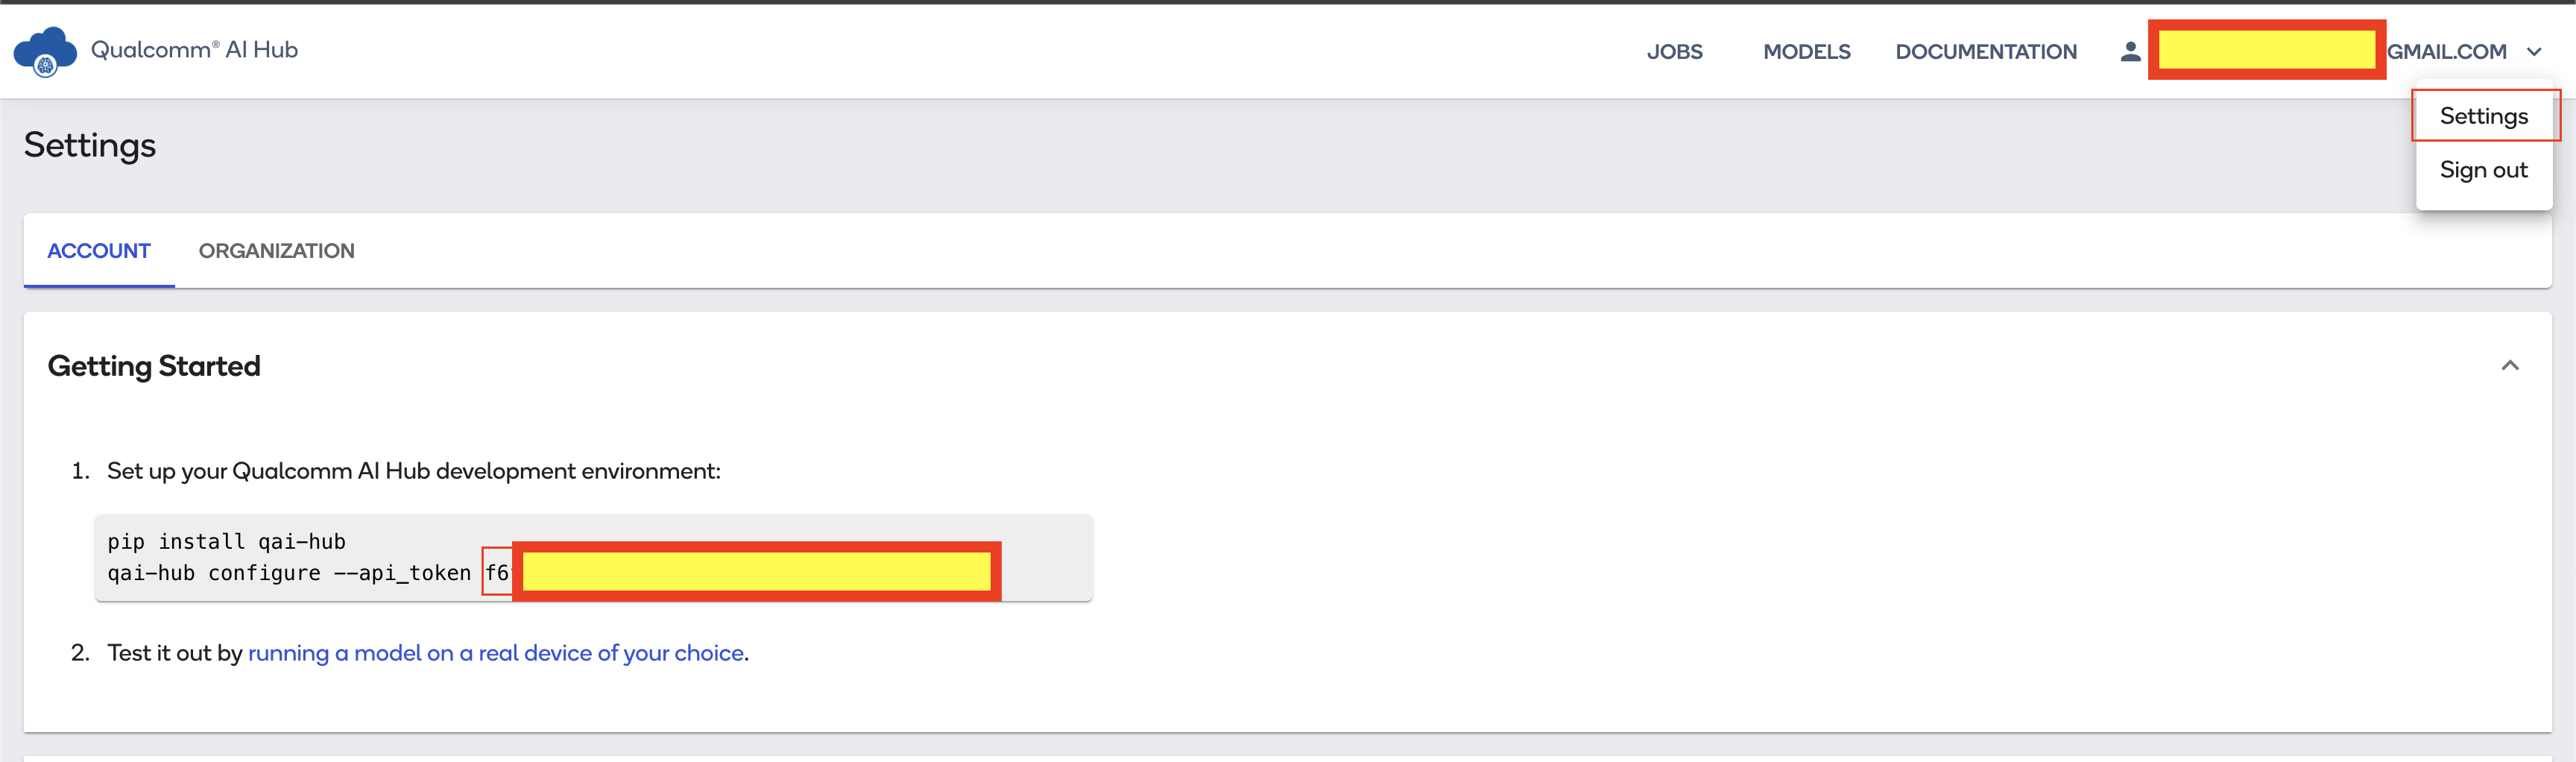

Please note if you're using custom conda env, replace, 

```python
qai-hub configure --api_token <your token> > /dev/null
```

with full python bin path for qai-hub,

```python
~/anaconda3/envs/test-aihub/bin/qai-hub configure --api_token <your token> > /dev/null
```

In [ ]:
%%bash
qai-hub configure --api_token <your token> > /dev/null 

### Step 2: Preprocess sample image input

Before invoking the PyTorch model, the raw image input needs to be pre-processed into the appropriate tensor format.

Ultralytics does this under the hood when invoking the model, but we need to do it manually here before passing the tensor input to the device.


In [ ]:
import qai_hub as hub

In [ ]:
sample_image_path = glob.glob(f"{data_path}/images/test/*")[0]
print(f"found {len(sample_image_path)} images")
model.predictor.setup_source(sample_image_path)
for (_, raw_input, _) in model.predictor.dataset:
    break
model_input = model.predictor.preprocess(raw_input).cpu()

### Step 3: Compile the model

The first step is converting the PyTorch model into a format that can run on the device.

This demo uses a Windows laptop powered by the Snapdragon X Elite hardware. This device uses the `ONNX` model format, which we will configure during compilation.

[Click here](https://app.aihub.qualcomm.com/docs/hub/compile_examples.html) to learn more about compilation on Qualcomm AI Hub.


In [ ]:
target_device = hub.Device("Snapdragon X Elite CRD")
model_name = "yolov8_defect_detection"

# Set the model to export mode to omit training outputs from the model
detect_module = model.model.model[-1]
detect_module.export = True
detect_module.format = "onnx"

# Trace the model to torchscript format
traced_model = torch.jit.trace(model.model.cpu(), model_input, check_trace=False)

In [ ]:
# Upload the model to AI Hub for compilation to ONNX
compile_job = hub.submit_compile_job(
    model=traced_model,
    input_specs={"image": (model_input.shape, "float32")},
    device=target_device,
    name=model_name,
    options="--target_runtime onnx"
)

### Step 4: Inference the model on a real device

Run the compiled model on a real cloud-hosted Snadragon device using the same model input we verified locally with PyTorch.

[Click here](https://app.aihub.qualcomm.com/docs/hub/inference_examples.html) to learn more about on-device inference on AI Hub.

In [ ]:
# Run inference on a cloud hosted device with the sample input
inference_job = hub.submit_inference_job(
    model=compile_job.get_target_model(),
    inputs={"image": [model_input.numpy()]},
    device=target_device,
    name=model_name,
)

# Download the output data from the device
on_device_output = inference_job.download_output_data()

# Post-process the raw output data
on_device_result = model.predictor.postprocess(
    torch.from_numpy(on_device_output["output_0"][0]), model_input, raw_input
)

# Display the bounding box outputs and verify they matched PyTorch results
Image.fromarray(on_device_result[0].plot())

### Step 5: Profile the model

Profiling measures the latency of the model when run on device. It reports the minimum value over 100 invocations of the model to best isolate model inference time from other processes on the device.

[Click here](https://app.aihub.qualcomm.com/docs/hub/profile_examples.html) to learn more about profiling on AI Hub.

In [ ]:
# Run profiling on a cloud hosted device
profile_job = hub.submit_profile_job(
    model=compile_job.get_target_model(),
    device=target_device,
    name=model_name,
)

In [ ]:
# Download the profiling details and display the inference time in milliseconds (ms)
profile_data = profile_job.download_profile()
time_ms = profile_data["execution_summary"]["estimated_inference_time"] / 1000
print(f"On-device latency: {time_ms:.1f}ms")

### Step 6: Deploy the compiled model to your device

Run the command below to download the compiled model.

The compiled model can be used in conjunction with the AI Hub sample application [hosted here](https://github.com/quic/ai-hub-apps/tree/main/apps/windows/cpp/ObjectDetection). This application uses the model to run object detection on a Windows laptop powered by Snapdragon that you have locally.

In [ ]:
compile_job.download_target_model("yolov8")

In [ ]:
print("Done, you now have an edge deployable model ✅")